In [ ]:
from IPython.core.display import HTML
HTML("""
<style>

div.cell { /* Tunes the space between cells */
margin-top:1em;
margin-bottom:1em;
}

div.text_cell_render h1 { /* Main titles bigger, centered */
font-size: 2.2em;
line-height:1.4em;
text-align:center;
}

div.text_cell_render h2 { /*  Parts names nearer from text */
margin-bottom: -0.4em;
}


div.text_cell_render { /* Customize text cells */
font-family: 'Times New Roman';
font-size:1.5em;
line-height:1.4em;
padding-left:3em;
padding-right:3em;
}
</style>
""")

# Dota2 contest

По первым 5 минутам игры предсказать, какая из команд победит: Radiant или Dire?

https://inclass.kaggle.com/c/dota-2-win-probability-prediction

## Предметная область

Dota 2 — многопользовательская компьютерная игра жанра MOBA. Игроки играют между собой матчи. В каждом матче участвует две команды, 5 человек в каждой. Одна команда играет за светлую сторону (The Radiant), другая — за тёмную (The Dire). Цель каждой команды — уничтожить главное здание базы противника (трон).

### Как проходит матч

#### 1. Выбор героев

Всего в игре чуть более 100 различных героев (персонажей). Герои различаются между собой своими характеристиками и способностями. От комбинации выбранных героев во многом зависит успех команды.

#### 2. Основная игра

Игроки могут получать золото и опыт за убийство чужих героев или прочих юнитов. Накопленный опыт влияет на уровень героя, который в свою очередь позволяет улучшать способности. За накопленное золото игроки покупают предметы, которые улучшают характеристики героев или дают им новые способности.

После смерти герой отправляется в "таверну" и возрождается только по прошествии некоторого времени, таким образом команда на некоторое время теряет игрока, однако игрок может досрочно выкупить героя из таверны за определенную сумму золота.

#### 3. Конец игры

Игра заканчивается, когда одна из команд разрушет определенное число "башен" противника и уничтожает трон.

## Признаки

- `match_id`: идентификатор матча в наборе данных
- `start_time`: время начала матча (unixtime)
- `lobby_type`: тип комнаты, в которой собираются игроки (расшифровка в `dictionaries/lobbies.csv`)

- Наборы признаков для каждого игрока (игроки команды Radiant — префикс `rN`, Dire — `dN`):
    - `rN_hero`: герой игрока (расшифровка в dictionaries/heroes.csv)
    - `rN_level`: максимальный достигнутый уровень героя (за первые 5 игровых минут)
    - `rN_xp`: максимальный полученный опыт
    - `rN_gold`: достигнутая ценность героя
    - `rN_lh`: число убитых юнитов
    - `rN_kills`: число убитых игроков
    - `rN_deaths`: число смертей героя
    - `rN_items`: число купленных предметов

- Признаки события "первая кровь" (first blood). Если событие "первая кровь" не успело произойти за первые 5 минут, то признаки принимают пропущенное значение
    - `first_blood_time`: игровое время первой крови
    - `first_blood_team`: команда, совершившая первую кровь (0 — Radiant, 1 — Dire)
    - `first_blood_player1`: игрок, причастный к событию
    - `first_blood_player2`: второй игрок, причастный к событию

- Признаки для каждой команды (префиксы `radiant_` и `dire_`)
    - `radiant_bottle_time`: время первого приобретения командой предмета "bottle"
    - `radiant_courier_time`: время приобретения предмета "courier" 
    - `radiant_flying_courier_time`: время приобретения предмета "flying_courier" 
    - `radiant_tpscroll_count`: число предметов "tpscroll" за первые 5 минут
    - `radiant_boots_count`: число предметов "boots"
    - `radiant_ward_observer_count`: число предметов "ward_observer"
    - `radiant_ward_sentry_count`: число предметов "ward_sentry"
    - `radiant_first_ward_time`: время установки командой первого "наблюдателя", т.е. предмета, который позволяет видеть часть игрового поля

- Итог матча (данные поля отсутствуют в тестовой выборке, поскольку содержат информацию, выходящую за пределы первых 5 минут матча)
    - `duration`: длительность
    - `radiant_win`: 1, если победила команда Radiant, 0 — иначе
    - Состояние башен и барраков к концу матча (см. описание полей набора данных)
        - `tower_status_radiant`
        - `tower_status_dire`
        - `barracks_status_radiant`
        - `barracks_status_dire`

In [71]:
# магическая функция, чтобы графики рисовались в ноутбуке, а не в отдельном окне
%matplotlib inline
import matplotlib # графики
import numpy as np # библиотека для вычислений, там есть все полезные математические функции
import matplotlib.pyplot as plt # графики
import pandas as pd # утилиты для работы с данными, умеет csv, sql и так далее...
pd.set_option('display.max_columns', 500)
import seaborn as sns # красивые графики
sns.set_style("dark")
plt.rcParams['figure.figsize'] = 16, 12 # увеличиваем размер картинок

from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score

In [65]:
# df - data frame.
# Загружаем тренировочную выборку
df = pd.read_csv("data/features.csv.zip", compression='zip', index_col='match_id')
df.head()

,start_time,lobby_type,r1_hero,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,r2_hero,r2_level,r2_xp,r2_gold,r2_lh,r2_kills,r2_deaths,r2_items,r3_hero,r3_level,r3_xp,r3_gold,r3_lh,r3_kills,r3_deaths,r3_items,r4_hero,r4_level,r4_xp,r4_gold,r4_lh,r4_kills,r4_deaths,r4_items,r5_hero,r5_level,r5_xp,r5_gold,r5_lh,r5_kills,r5_deaths,r5_items,d1_hero,d1_level,d1_xp,d1_gold,d1_lh,d1_kills,d1_deaths,d1_items,d2_hero,d2_level,d2_xp,d2_gold,d2_lh,d2_kills,d2_deaths,d2_items,d3_hero,d3_level,d3_xp,d3_gold,d3_lh,d3_kills,d3_deaths,d3_items,d4_hero,d4_level,d4_xp,d4_gold,d4_lh,d4_kills,d4_deaths,d4_items,d5_hero,d5_level,d5_xp,d5_gold,d5_lh,d5_kills,d5_deaths,d5_items,first_blood_time,first_blood_team,first_blood_player1,first_blood_player2,radiant_bottle_time,radiant_courier_time,radiant_flying_courier_time,radiant_tpscroll_count,radiant_boots_count,radiant_ward_observer_count,radiant_ward_sentry_count,radiant_first_ward_time,dire_bottle_time,dire_courier_time,dire_flying_courier_time,dire_tpscroll_count,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time,duration,radiant_win,tower_status_radiant,tower_status_dire,barracks_status_radiant,barracks_status_dire
match_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1430198770,7,11,5,2098,1489,20,0,0,7,67,3,842,991,10,0,0,4,29,5,1909,1143,10,0,0,8,20,3,757,741,6,0,0,7,105,3,732,658,4,0,1,11,4,3,1058,996,12,0,0,6,42,4,1085,986,12,0,0,4,21,5,2052,1536,23,0,0,6,37,3,742,500,2,0,0,8,84,3,958,1003,3,1,0,9,7.0,1.0,9.0,NaN,134.0,-80.0,244.0,2,2,2,0,35.0,103.0,-84.0,221.0,3,4,2,2,-52.0,2874,1,1796,0,51,0
1,1430220345,0,42,4,1188,1033,9,0,1,12,49,4,1596,993,10,0,1,7,67,4,1506,1502,18,1,0,7,37,3,669,631,7,0,0,7,26,2,415,539,1,0,0,5,39,5,1960,1384,16,0,0,8,88,3,640,566,1,0,1,5,79,3,720,1350,2,2,0,12,7,2,440,583,0,0,0,7,12,4,1470,1622,24,0,0,9,54.0,1.0,7.0,NaN,173.0,-80.0,NaN,2,0,2,0,-20.0,149.0,-84.0,195.0,5,4,3,1,-5.0,2463,1,1974,0,63,1
2,1430227081,7,33,4,1319,1270,22,0,0,12,98,3,1314,775,6,0,0,6,20,3,1297,909,0,1,0,6,27,5,2360,2096,26,1,1,6,4,3,1395,1627,27,0,0,9,22,5,2305,2028,19,1,1,10,66,3,1024,959,19,0,1,10,86,3,755,620,3,0,0,8,29,4,1319,667,4,0,0,7,80,3,1350,1512,25,0,0,7,224.0,0.0,3.0,NaN,63.0,-82.0,NaN,2,5,2,1,-39.0,45.0,-77.0,221.0,3,4,3,1,13.0,2130,0,0,1830,0,63
3,1430263531,1,29,4,1779,1056,14,0,0,5,30,2,539,539,1,0,0,6,75,5,2037,1139,15,0,0,6,37,2,591,499,0,0,0,6,41,3,712,1075,12,0,0,6,96,5,1878,1174,17,0,0,6,48,3,732,1468,22,0,0,10,15,4,1681,1051,11,0,0,7,102,2,674,537,1,0,0,7,20,2,510,499,0,0,0,7,NaN,NaN,NaN,NaN,208.0,-75.0,NaN,0,3,2,0,-30.0,124.0,-80.0,184.0,0,4,2,0,27.0,1459,0,1920,2047,50,63
4,1430282290,7,13,4,1431,1090,8,1,0,8,27,2,629,552,0,0,1,7,30,3,884,927,0,1,0,8,72,3,925,1439,16,1,0,11,93,4,1482,880,7,0,0,8,26,3,704,586,1,0,2,9,69,3,1169,1665,20,1,0,7,22,3,1055,638,1,0,0,9,25,5,1815,1275,18,0,0,8,8,4,1119,904,6,0,1,7,-21.0,1.0,6.0,NaN,166.0,-81.0,181.0,1,4,2,0,46.0,182.0,-80.0,225.0,6,3,3,0,-16.0,2449,0,4,1974,3,63


# Исследуем данные

Для начала посмотрим информацию о датафреме и базовые характеристики признаков

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97230 entries, 0 to 114406
Columns: 108 entries, start_time to barracks_status_dire
dtypes: float64(12), int64(96)
memory usage: 80.9 MB


In [11]:
df.describe()

,start_time,lobby_type,r1_hero,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,r2_hero,r2_level,r2_xp,r2_gold,r2_lh,r2_kills,r2_deaths,r2_items,r3_hero,r3_level,r3_xp,r3_gold,r3_lh,r3_kills,r3_deaths,r3_items,r4_hero,r4_level,r4_xp,r4_gold,r4_lh,r4_kills,r4_deaths,r4_items,r5_hero,r5_level,r5_xp,r5_gold,r5_lh,r5_kills,r5_deaths,r5_items,d1_hero,d1_level,d1_xp,d1_gold,d1_lh,d1_kills,d1_deaths,d1_items,d2_hero,d2_level,d2_xp,d2_gold,d2_lh,d2_kills,d2_deaths,d2_items,d3_hero,d3_level,d3_xp,d3_gold,d3_lh,d3_kills,d3_deaths,d3_items,d4_hero,d4_level,d4_xp,d4_gold,d4_lh,d4_kills,d4_deaths,d4_items,d5_hero,d5_level,d5_xp,d5_gold,d5_lh,d5_kills,d5_deaths,d5_items,first_blood_time,first_blood_team,first_blood_player1,first_blood_player2,radiant_bottle_time,radiant_courier_time,radiant_flying_courier_time,radiant_tpscroll_count,radiant_boots_count,radiant_ward_observer_count,radiant_ward_sentry_count,radiant_first_ward_time,dire_bottle_time,dire_courier_time,dire_flying_courier_time,dire_tpscroll_count,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time,duration,radiant_win,tower_status_radiant,tower_status_dire,barracks_status_radiant,barracks_status_dire
count,9.723000e+04,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,77677.000000,77677.000000,77677.000000,53243.000000,81539.000000,96538.000000,69751.000000,97230.000000,97230.000000,97230.000000,97230.000000,95394.000000,81087.000000,96554.000000,71132.000000,97230.000000,97230.000000,97230.000000,97230.000000,95404.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000,97230.000000
mean,1.444232e+09,2.630999,51.517104,3.442672,1233.405801,1147.899702,11.231996,0.357009,0.362285,8.271315,52.183452,3.364661,1189.223676,1107.863993,10.471747,0.348709,0.363550,8.275584,52.710491,3.353924,1182.879965,1099.643742,10.333004,0.342723,0.357338,8.273527,52.648092,3.308896,1159.088481,1082.090240,9.981909,0.337746,0.357307,8.275049,52.625630,3.304237,1158.586167,1082.057061,9.995351,0.337262,0.352782,8.288491,51.990106,3.461123,1238.855765,1151.018184,11.253841,0.372262,0.344091,8.296380,52.708547,3.388933,1199.858809,1108.633436,10.460424,0.356238,0.347012,8.310419,52.755137,3.378638,1193.554438,1103.273702,10.386918,0.353533,0.347732,8.305420,52.922421,3.337725,1171.952155,1088.711653,10.035349,0.354952,0.341860,8.319665,53.059694,3.345274,1177.395351,1089.558850,10.053739,0.356063,0.342538,8.323048,97.688029,0.521815,4.593483,4.383224,126.800255,-80.059510,215.987126,2.994775,3.312527,2.431719,0.716250,-6.875747,127.215028,-80.191893,214.870536,2.965566,3.349553,2.448339,0.689119,-6.901922,2332.247886,0.518503,1309.227790,1286.310820,40.599095,41.337036
std,5.515393e+06,2.835761,32.564211,1.111741,566.588895,464.111662,9.041620,0.663889,0.626704,2.497575,32.674077,1.097536,555.363510,458.001007,8.972073,0.654060,0.624236,2.433864,32.560923,1.092126,554.899600,454.727127,8.950871,0.647774,0.618071,2.440139,32.670519,1.092502,550.937530,450.353291

Если внимательно посмотреть, то мы увидем что в данных есть пропуски - NaN значения.

### Что делать с пропусками?
- удалить все строки с пропущенными данными
- заполнить пропуски 0
- заполнить пропуски совсем нехарактерными значениями (большое отрицательное число)
- заполнить пропуск средним, медианой
- заполнить пропуск средним в подгруппе по какому-то другому признаку

Для начала посмотрим какие признаки имеют пропуски

In [17]:
nan_features = [i for i, v in df.count().iteritems() if v < df.shape[0]]
nan_features

['first_blood_time',
 'first_blood_team',
 'first_blood_player1',
 'first_blood_player2',
 'radiant_bottle_time',
 'radiant_courier_time',
 'radiant_flying_courier_time',
 'radiant_first_ward_time',
 'dire_bottle_time',
 'dire_courier_time',
 'dire_flying_courier_time',
 'dire_first_ward_time']

In [20]:
df[nan_features].describe()

,first_blood_time,first_blood_team,first_blood_player1,first_blood_player2,radiant_bottle_time,radiant_courier_time,radiant_flying_courier_time,radiant_first_ward_time,dire_bottle_time,dire_courier_time,dire_flying_courier_time,dire_first_ward_time
count,77677.000000,77677.000000,77677.000000,53243.000000,81539.000000,96538.000000,69751.000000,95394.000000,81087.000000,96554.000000,71132.000000,95404.000000
mean,97.688029,0.521815,4.593483,4.383224,126.800255,-80.059510,215.987126,-6.875747,127.215028,-80.191893,214.870536,-6.901922
std,82.625879,0.499527,2.886984,2.870915,61.427907,15.814209,34.604997,39.508650,62.442018,15.261950,34.137158,40.701397
min,-78.000000,0.000000,0.000000,0.000000,-37.000000,-90.000000,180.000000,-236.000000,-45.000000,-90.000000,180.000000,-84.000000
25%,15.000000,0.000000,2.000000,2.000000,84.000000,-86.000000,186.000000,-31.000000,83.000000,-86.000000,185.000000,-31.000000
50%,93.000000,1.000000,5.000000,4.000000,131.000000,-83.000000,204.000000,-15.000000,131.000000,-84.000000,203.000000,-16.000000
75%,155.000000,1.000000,7.000000,7.000000,164.000000,-79.000000,241.000000,9.000000,165.000000,-79.000000,238.000000,8.000000
max,300.000000,1.000000,9.000000,9.000000,300.000000,300.000000,300.000000,300.000000,300.000000,296.000000,300.000000,300.000000


Так как у нас есть только первые 5 минут игры, то некоторые характеристки еще не были заполнены. 
Напрмимер, время покупки курьера или first blood.

Интересные детали в данных:
- *_time бывает отрицательным. Это означает, что отсчет времени начала игры немного смещен. Там есть период времени для покупок товарами, распределения внутри команды и так далее. Вполне возмодно отрицательное время не стоит делать положительным. В нем может заключаться некоторый смысл.
- другие признаки категориальные и они распределены от 0 до N. Заполнять нулями на мой взгляд странно. Это может запутать алгоритм.

Предлагаю время заполнить `max + std`

Для категориальных признаков завести специальный номер

In [66]:
def fill_na(df, nan_features):
    times = [f for f in nan_features if f.find('time') != -1]
    categorical = [f for f in nan_features if f.find('time') == -1]
    
    df[times] = df[times].fillna(301.0)
    df[categorical] = df[categorical].fillna(-1)
    return df
    
fill_na(df, nan_features)
[i for i, v in df.count().iteritems() if v < df.shape[0]]

[]

In [73]:
X = df.drop(['start_time', 'duration', 'radiant_win', 'tower_status_radiant', 'tower_status_dire','barracks_status_radiant', 'barracks_status_dire'], axis=1)
y = df['radiant_win']

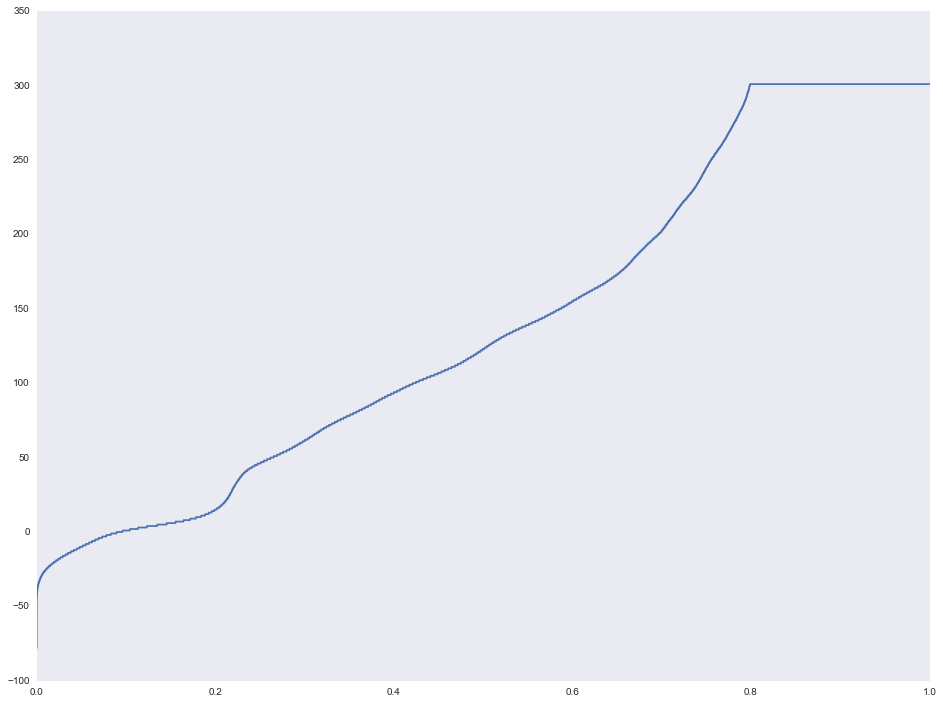

In [74]:
support = np.linspace(0, 1, df.shape[0])
plt.plot(support, df['first_blood_time'].sort_values())

# Глупое предсказание

В качестве базового предсказателя часто берут какой-то константный предсказатель, чтобы понять, что хуже него ни в коем случае быть нельзя.

В нашем случае выборка сбалансированная, поэтому если мы будем просто предсказывать что победит вторая команда, то мы получим точность в 50%.

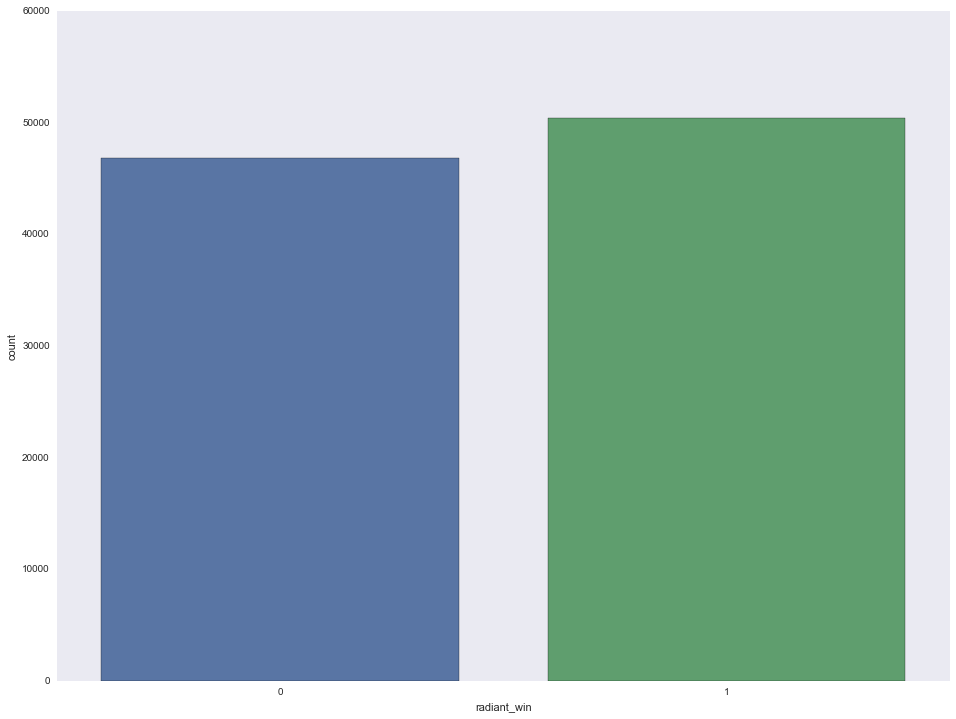

In [69]:
# почти сбалансированные данные, отлично
sns.countplot(data=df, x='radiant_win')

In [78]:
clf = DummyClassifier(random_state=42)
scores = cross_val_score(clf, X, y, scoring='roc_auc')
print("ROC_AUC: mean={}, std={}".format(scores.mean(), 2*scores.std()))

ROC_AUC: mean=0.5003919299939009, std=0.005770428948303072


# Решаем в Лоб

Иногда полезно попробовать парочку моделей на чистых признаках без предподготовки. Это хорошая стартовая линия, по ней мы сможем ориентироваться, улучшаем ли мы модель или нет.

Можно поробовать: 
- Градиентный бустинг на деревьях
- Cлучайный лес
- K ближайших соседей
- Линеный классификатор
- Машину опорных векторов